In [1]:
import os
import spacy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from gensim.models import Word2Vec

# Завантаження токенізатора SpaCy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
# Функція токенізації тексту
def tokenize(texts, markers, tokenizer):
    result_tokens, result_labels = [], []

    for text, loc_markers in zip(texts, markers):
        doc = tokenizer(text)
        tokens = [token.text for token in doc]
        labels = ['O'] * len(tokens)

        for start, end in loc_markers:
            for i, token in enumerate(doc):
                if start <= token.idx < end:
                    labels[i] = 'B-LOC' if token.idx == start else 'I-LOC'

        result_tokens.append(tokens)
        result_labels.append(labels)
    
    return result_tokens, result_labels



Feeling the tranquility and serenity of the Andes Mountains #naturelover #mountainscape
['Andes']


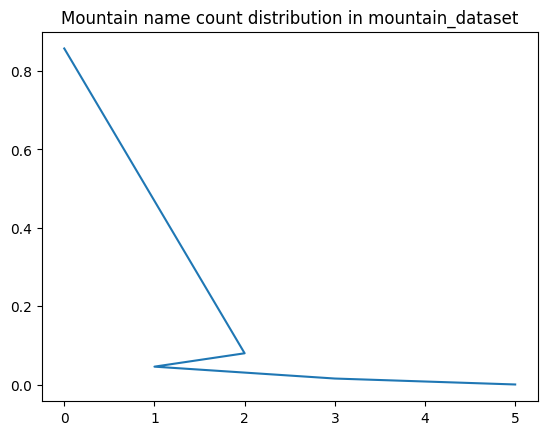

Mountains       82
Mount           45
Alps            34
Andes           23
Himalayas       19
Taurus          12
Range           12
Rhodope          9
Everest          9
Rocky            8
Appalachian      8
Fuji             7
Shan             7
Kilimanjaro      7
Scandinavian     7
Rainier          5
Sierra           5
Olympus          5
Denali           5
Kunlun           5
Dividing         4
Atlas            4
Patagonian       4
Drakensberg      4
Great            4
Brooks           4
Carpathian       4
Tien             4
Blue             4
Cascade          4
Ridge            4
Tatra            4
Tian             3
Cook             3
Apennine         3
Dolomites        3
Ural             3
Elbrus           3
mountains        3
Nevada           3
Rwenzori         3
Kenya            2
Columbia         2
St.              2
Occidental       2
Madre            2
Helens           2
Icefield         2
K2               1
Dolomite         1
Logan            1
Eiger            1
Name: count,

In [2]:
# Використовуємо %run для виконання іншого блокнота
%run data_loading_and_preprocessing.ipynb


In [3]:
# Функція обробки датасету
def process_dataset(dataset, output_path, n_splits=100):
    if os.path.exists(output_path):
        # Якщо файл існує, зчитуємо його для додавання нових даних
        existing_data = pd.read_csv(output_path)
    else:
        existing_data = pd.DataFrame()

    for split in tqdm(np.array_split(dataset, n_splits), desc="Processing dataset"):
        tokens, labels = tokenize(split['text'], split['markers'], nlp)
        new_data = pd.DataFrame({'tokens': tokens, 'labels': labels})
        
        # Додаємо нові дані до існуючого
        existing_data = pd.concat([existing_data, new_data], ignore_index=True)

    # Записуємо оновлений DataFrame у CSV файл
    existing_data.to_csv(output_path, index=False)




In [4]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Обробка Mountain NER Dataset
process_dataset(mountain_df, 'save_mountain_dataset_processed.csv')


Processing dataset: 100%|██████████| 100/100 [00:02<00:00, 41.81it/s]


In [5]:
# Завантаження обробленого датасету
processed_dataset = pd.read_csv('save_mountain_dataset_processed.csv')
train_dataset = processed_dataset.iloc[:1400].reset_index(drop=True)
holdout_dataset = processed_dataset.iloc[1400:].reset_index(drop=True)



In [6]:
# Обчислення кількості гір у кожному тексті
train_dataset['mountain_count'] = train_dataset['labels'].apply(lambda labels: np.sum(np.array(labels) == 'B-LOC'))

# Створення розбивки для KFold
train_dataset['kfold_col'] = np.clip(train_dataset['mountain_count'], a_min=None, a_max=10)


In [7]:
train_dataset['kfold_col'].value_counts()


kfold_col
0    1400
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True)
folds = list(kf.split(train_dataset))




In [9]:
# Токенізація для навчання
sentences = train_dataset['tokens'].to_list()
embeddor = Word2Vec(sentences, vector_size=300, epochs=50, workers=4)

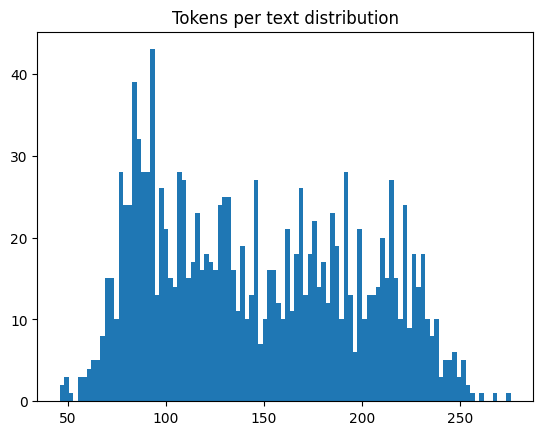

In [10]:
# Клас для Torch Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, embeddor, max_len=128):
        self.texts = texts
        self.labels = labels
        self.embeddor = embeddor.wv
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx][:self.max_len]
        labels = self.labels[idx][:self.max_len]
        embeddings = [self.embeddor[token] if token in self.embeddor else np.zeros(self.embeddor.vector_size) for token in tokens]

        return (
            torch.tensor(embeddings, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.float32)
        )

# Візуалізація розподілу кількості токенів
tokens_per_text = train_dataset['tokens'].apply(len)
plt.hist(tokens_per_text, bins=100)
plt.title('Tokens per text distribution')
plt.show()


In [11]:
# Визначення максимальної довжини послідовності
SEQ_LEN = int(np.quantile(tokens_per_text, 0.95))
print(f"0.95 quantile of token lengths: {SEQ_LEN}")

0.95 quantile of token lengths: 231
